### **Stap 2: Data ophalen van Coinbase**

In [1]:
import requests
import pandas as pd

def fetch_coinbase_data(symbol="XRP-USD", granularity=3600):
    """
    Haalt historische data op van Coinbase
    Args:
    - symbol (str): Het trading pair, bijvoorbeeld 'XRP-USD'.
    - granularity (int): Interval in seconden (bijv. 3600 = 1 uur).
    """
    url = f"https://api.exchange.coinbase.com/products/{symbol}/candles"
    params = {
        "granularity": granularity # Tijdinterval, bijvoorbeeld 3600s = 1 uur.
    }
    response = requests.get(url, params=params)

    if response.status_code != 200:
        raise Exception(f"API Error: {response.status_code}, {response.text}")
    
    # Converteer de data naar een Pandas DataFrame
    data = response.json()
    df = pd.DataFrame(data, columns=["time", "low", "high", "open", "close", "volume"])

    # Converteer de tijdstempel naar datetime
    df["time"] = pd.to_datetime(df["time"], unit="s")

    # Sorteer op tijd
    df = df.sort_values(by="time").reset_index(drop=True)
    return df

# Voorbeeldgebruik
df = fetch_coinbase_data("XRP-USD", granularity=3600)
print(df.head()) 

                 time     low    high    open   close        volume
0 2024-12-24 09:00:00  2.2260  2.2514  2.2482  2.2346  1.254679e+06
1 2024-12-24 10:00:00  2.2194  2.2384  2.2346  2.2244  1.592874e+06
2 2024-12-24 11:00:00  2.2210  2.2442  2.2248  2.2418  1.826160e+06
3 2024-12-24 12:00:00  2.2260  2.2436  2.2419  2.2369  1.965861e+06
4 2024-12-24 13:00:00  2.2319  2.3217  2.2380  2.3207  9.530128e+06


### **Stap 3: Data voorbereiden**

1. Visualiseer de sluitingsprijzen

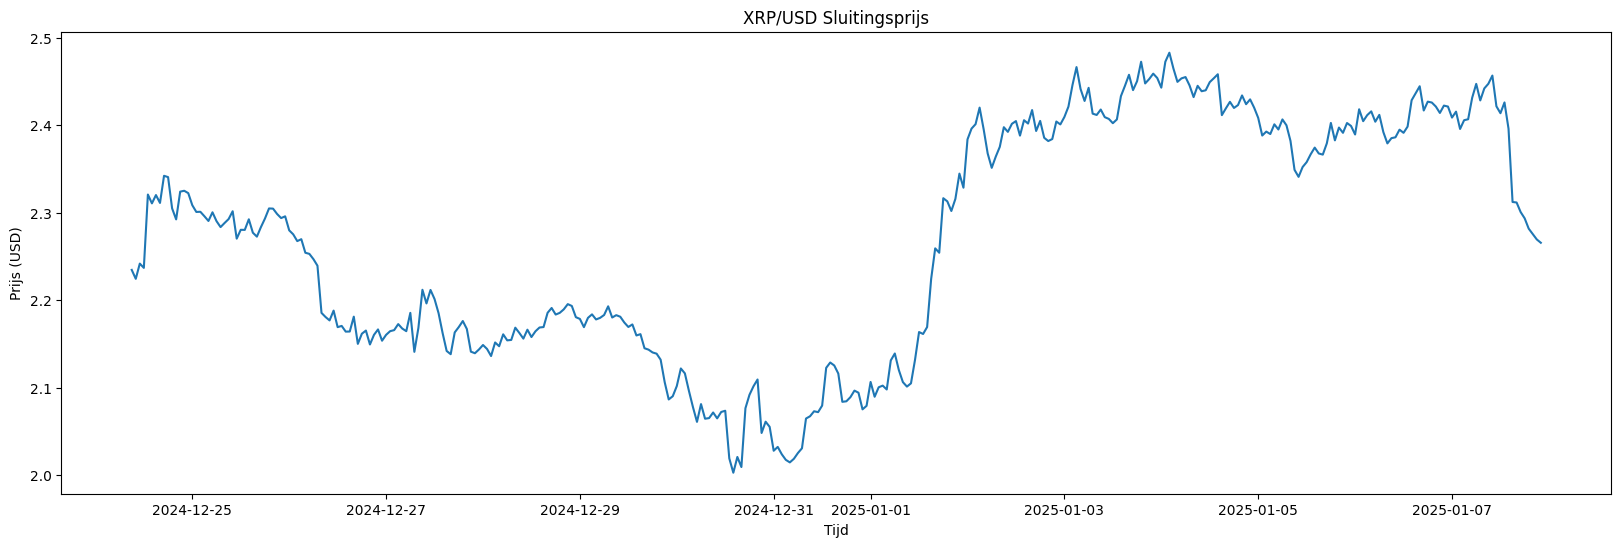

In [2]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 6))
plt.plot(df["time"], df["close"])
plt.title("XRP/USD Sluitingsprijs")
plt.xlabel("Tijd")
plt.ylabel("Prijs (USD)")
plt.show()

2. Normaliseer de data

In [3]:
from sklearn.preprocessing import MinMaxScaler

scalar = MinMaxScaler()
df["close_scaled"] = scalar.fit_transform(df[["close"]])

3. Trainingsset maken

In [4]:
import numpy as np

def create_sequences(data, lookback=60):
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data[i:i+lookback])
        y.append(data[i+lookback])
    return np.array(X), np.array(y)

close_prices = df["close_scaled"].values
X, y = create_sequences(close_prices, lookback=60)
print(f"Input shape: {X.shape}, Output shape: {y.shape}")

# Train-Test Split
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

Input shape: (290, 60), Output shape: (290,)


### **Stap 4: Bouw een LSTM-model**

In [5]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization

# Model bouwen
model = Sequential([
    LSTM(50, return_sequences=False, input_shape=(X.shape[1], 1)),
    BatchNormalization(),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer="adam", loss="mean_squared_error")

c:\Users\NvanOort\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [6]:
from tensorflow.keras.callbacks import LearningRateScheduler

def lr_scheduler(epoch, lr):
    return lr * 0.95

lr_scheduler = LearningRateScheduler(lr_scheduler)

history = model.fit(
    X_train, y_train,
    epochs=20, 
    batch_size=32, validation_data=(X_test, y_test), 
    callbacks=[lr_scheduler]
)

Epoch 1/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 0.4610 - val_loss: 0.3686 - learning_rate: 9.5000e-04
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.4264 - val_loss: 0.3807 - learning_rate: 9.0250e-04
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.3058 - val_loss: 0.2711 - learning_rate: 8.5737e-04
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.2572 - val_loss: 0.2758 - learning_rate: 8.1451e-04
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.2265 - val_loss: 0.2040 - learning_rate: 7.7378e-04
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1616 - val_loss: 0.1855 - learning_rate: 7.3509e-04
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.1547 - val_loss: 0.1740 - learning_rate: 6.9834e-04
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.1257 - val_loss: 0.1389 - learning_rate: 6.6342e-04
Epoch 9/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.1120 - val_loss: 0.1269 - learning_rate: 6.3025e-04
E

### **Stap 5: Voorspellen en visualiseren**

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
MAE: 0.25769776722480503, RMSE: 0.2726348961986432


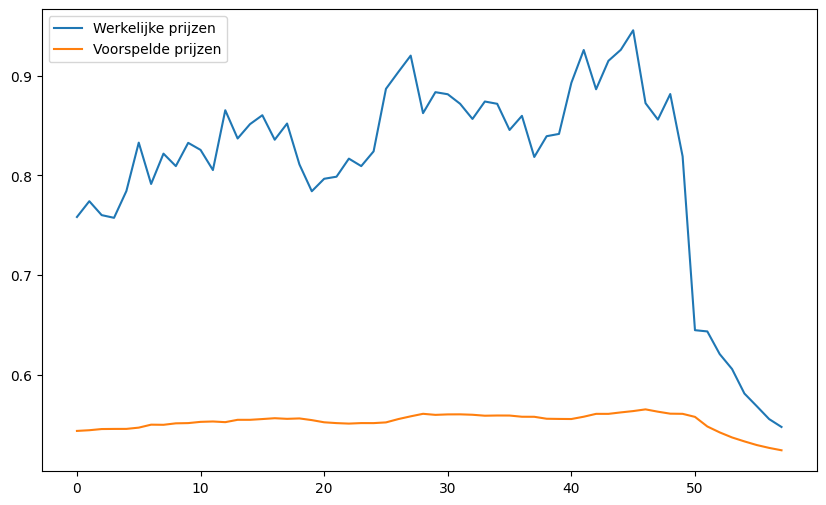

In [7]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Voorspellen
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"MAE: {mae}, RMSE: {rmse}")

# Visualiseer de resultaten
plt.figure(figsize=(10, 6))
plt.plot(y_test, label="Werkelijke prijzen")
plt.plot(y_pred, label="Voorspelde prijzen")
plt.legend()
plt.show()